# Forest Fire Classification

## Download and prepare the data

Download fire images for classification:

In [1]:
#!python ./scripts/data/data_downloader.py \
#        -l https://nextcloud.th-deg.de/s/Ng7EmnGDi4dLPM7 \
#        -f fire.tar.gz \
#        -d ../data/

Download smoke images for classification:

In [2]:
#!python ./scripts/data/data_downloader.py \
#        -l https://nextcloud.th-deg.de/s/TR8qZCmtDQGX6bD \
#        -f smoke.tar.gz \
#        -d ../data/

Download non smoke and non fire images for classification:

In [3]:
#!python ./scripts/data_downloader/data_downloader_nextcloud.py \
#        -l https://nextcloud.th-deg.de/s/dEdKoEiQpeTmDM8 \
#        -f non-smoke-fire.tar.gz \
#        -d ../data/classification

## Import TensorFlow and other libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-06-23 17:37:00.834012: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-23 17:37:00.836976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 17:37:00.836985: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Explore the dataset

The dataset includes about 18733 broken (18344 good) pictures. The dataset contains three sub-directories. 

```
data/
    fire/
    non-smoke-fire/
    smoke/

In [5]:
whole_dir = pathlib.Path('./data/')
len(list(whole_dir.glob("*/*")))

18350

The count of the fire images:

In [6]:
len(list(whole_dir.glob("fire/*")))

3213

The count of the smoke images:

In [7]:
len(list(whole_dir.glob("smoke/*")))

12631

The count of the non-smoke-fire images:

In [8]:
len(list(whole_dir.glob("non-smoke-fire/*")))

2500

The dataset is highly unbalanced (3602 fire pictures, 12631 smoke images and 2500 non-smoke-fire) with too many samples - limit each class to have 1500 samples. Create a train and test directory with 1500 images of all the three classes.

### Load dataset

Load dataset with own implemented class with auto balance and split in train and test dir.

In [9]:
from scripts.classification.dataset import ForestFireDataSet

In [10]:
forst_fire_dataset = ForestFireDataSet('./data')

### Explore train and test dataset

#### Train dataset

In [11]:
train_dir = pathlib.Path('./data/train')
len(list(train_dir.glob("*/*")))

5250

In [12]:
len(list(train_dir.glob("fire/*")))

1750

In [13]:
len(list(train_dir.glob("smoke/*")))

1750

In [14]:
len(list(train_dir.glob("non-smoke-fire/*")))

1750

#### Test dataset

In [15]:
test_dir = pathlib.Path('./data/test')
len(list(test_dir.glob("*/*")))

2250

In [16]:
len(list(test_dir.glob("fire/*")))

750

In [17]:
len(list(test_dir.glob("smoke/*")))

750

In [18]:
len(list(test_dir.glob("non-smoke-fire/*")))

750

## Load data 

In [19]:
from scripts.classification.dataloader import ForestFireDataLoader

In [20]:
forest_fire_dataloader = ForestFireDataLoader(forst_fire_dataset)

Found 5250 files belonging to 3 classes.
Using 4200 files for training.
Found 5250 files belonging to 3 classes.
Using 1050 files for validation.


2022-06-23 17:37:06.516985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-23 17:37:06.517005: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-23 17:37:06.517018: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2022-06-23 17:37:06.517223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
class_names = forest_fire_dataloader.train_ds.class_names

## Visualize some data

In [22]:
import matplotlib.pyplot as plt

Plot the first nine images from the training dataset.

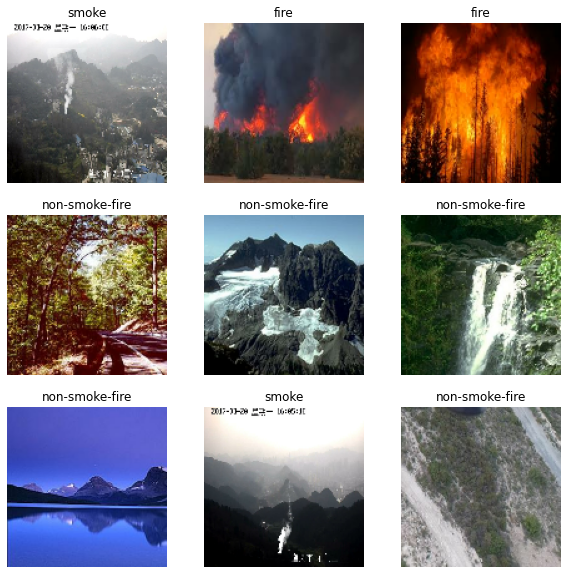

In [23]:
plt.figure(figsize=(10,10))
for images, labels in forest_fire_dataloader.train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(forest_fire_dataloader.train_ds.class_names[labels[i]])
        plt.axis("off")

## Configure the dataset for performance

Buffered prefetching is used to yield data from disk without having I/O blocking. The following two important methods should be used to loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

For more informations about both these methods, as well as how to cache data to disk in the *Prefetching* section, this guid helps: [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [24]:
forest_fire_dataloader.autotune()

## Create model and train

In [25]:
from scripts.classification.train import ForestFireClassification

In [26]:
forest_fire_classification = ForestFireClassification(forest_fire_dataloader, class_names)

In [28]:
forest_fire_classification.compile()

In [29]:
forest_fire_classification.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                      

In [30]:
history = forest_fire_classification.fit(10)

Epoch 1/10
132/132 [==============================] - 25s 144ms/step - loss: 0.5074 - accuracy: 0.8038 - val_loss: 0.3256 - val_accuracy: 0.8819
Epoch 2/10
132/132 [==============================] - 18s 140ms/step - loss: 0.2593 - accuracy: 0.8993 - val_loss: 0.1597 - val_accuracy: 0.9362
Epoch 3/10
132/132 [==============================] - 19s 143ms/step - loss: 0.2100 - accuracy: 0.9138 - val_loss: 0.2242 - val_accuracy: 0.9190
Epoch 4/10
132/132 [==============================] - 19s 143ms/step - loss: 0.1928 - accuracy: 0.9257 - val_loss: 0.1654 - val_accuracy: 0.9352
Epoch 5/10
132/132 [==============================] - 19s 146ms/step - loss: 0.1653 - accuracy: 0.9405 - val_loss: 0.2051 - val_accuracy: 0.9124
Epoch 6/10
132/132 [==============================] - 21s 161ms/step - loss: 0.1758 - accuracy: 0.9310 - val_loss: 0.1925 - val_accuracy: 0.9429
Epoch 7/10
132/132 [==============================] - 20s 154ms/step - loss: 0.1849 - accuracy: 0.9317 - val_loss: 0.1507 - val_ac

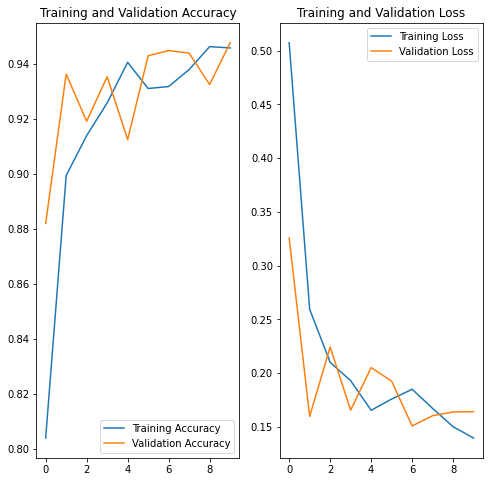

In [32]:
forest_fire_classification.show_training_results_plot(history, 10)

## Test model on test dataset

In [47]:
import numpy as np

from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [38]:
test_generator = ImageDataGenerator()

In [39]:
test_data_generator = test_generator.flow_from_directory(
    'data/test',
    target_size=(forst_fire_dataset.img_width, forst_fire_dataset.img_height),
    batch_size=32,
    shuffle=False)

Found 2250 images belonging to 3 classes.


In [40]:
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

In [42]:
predictions = forest_fire_classification.model.predict(test_data_generator, steps=test_steps_per_epoch)

71/71 [==============================] - 9s 128ms/step


In [50]:
predicted_classes = np.argmax(predictions, axis=1)

In [43]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [52]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)

In [53]:
print(report)

                precision    recall  f1-score   support

          fire       0.90      0.96      0.93       750
non-smoke-fire       0.97      0.89      0.93       750
         smoke       0.99      1.00      0.99       750

      accuracy                           0.95      2250
     macro avg       0.95      0.95      0.95      2250
  weighted avg       0.95      0.95      0.95      2250

